In [1]:
# Running Dist function with multiple 1 million samples and getting centroids, then clustering the centroids to 
# get cluster centroids for the entire day. 

# Issues with this file-- memory allocation, so I seem to only be able to have 5 samples of 1 million and I have to delete
# the original dataframe so ease up space. Ideally, this would be done with many samples of 10 million, not few with 1 mill.

In [2]:
import pandas as pd    
import math
import numpy as np
from copy import deepcopy
import random
import time
import multiprocessing 
import gc
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [3]:
# Reading in the data
start = time.time()
df = pd.read_csv('Netflow_Day2.csv')
end = time.time()
print(end - start)

178.28196477890015


In [4]:
# Splitting the data into samples-- 5, 1 million
start = time.time()
dfs = []
for i in range(5):
    df_samp = df.sample(n=1000000, replace=False, axis=0)
    df_samp = df_samp[["Time", "Duration", "SrcDevice", "DstDevice", "Protocol", "SrcPort", "DstPort", "SrcPackets",
              "DstPackets", "SrcBytes", "DstBytes"]]
    dfs.append(df_samp)
end = time.time()
print(end - start)

47.62558841705322


In [5]:
start = time.time()
del df
gc.collect()
end = time.time()
print(end - start)

2.5650713443756104


In [6]:
# Cosine Similarity (used in clustering algorithm)
def cosine_similarity(slope1, slope2):
    a = np.array([1,slope1])
    b = np.array([1,slope2])
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [7]:
# Modified kmeans so that the function takes in a dataframe and returns the centroids for it
def slope_classifier(df):
    
    #dfC = deepcopy(df)
    
    # Initializing the previous parameters because now the function takes in a dataframe and I know I want to use k=3
    k = 3
    x_coords = df["SrcPackets"]
    y_coords = df["DstPackets"]
    
    # Randomly assigning initial clusters
    slopeClusters = []
    for i in range(k):
        slopeClusters.append((random.uniform(0,math.pi/2)))
    
    # Finding the ratio of y to x (slope for each (x,y) coordinate)
    # Making x values of 0 very small to avoid divide by zero error
    xCopy = x_coords
    xCopy[xCopy==0] = 0.0000000000000000000001
    y = np.array(y_coords, dtype = 'float')
    x = np.array(xCopy, dtype = 'float')
    slopes = np.divide(y,x)
    
    
    # Instantiating and empty array of 0 as a place holder for the old slope clusters
    # will use this to calculate error as slope clusters change each iteration. Once the error
    # is 0, the clusters have stabilized
    old_slopeClusters = np.zeros(len(slopeClusters))
    error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
  
    # Running a loop until centroids stabilize (percent change from old cluster values to new is 0)
    while error.any() != 0:
        
        # Instantiating an empty array of 0s that will be populated with cluster assignments for each slope  
        clusters = np.zeros(len(slopes))
        
        # For each slope, find the cosine distance to each cluster. Cosine always return [0,1], with values
        # closer to 1 signifying that the two vectors are close; 0 that they are far apart. Finding the max
        # cosine value and the corresponding cluster will be assigned to that slope. 
        for i in range(len(slopes)):               
            distances = []
            for j in range(len(slopeClusters)):
                distances.append(cosine_similarity(slopes[i],slopeClusters[j]))
            cluster = np.argmax(distances)
            clusters[i] = cluster
        
               
        # Making a deep copy of the old centroids to use later for clacluating error
        old_slopeClusters = deepcopy(slopeClusters)
        
        
        # Finding new centroids by taking average of the values assigned to each cluster and
        # replacing the old cluster values with the new averages
        for m in range(k):
            points = [slopes[j] for j in range(len(slopes)) if clusters[j] == m]              
            slopeClusters[m] = sum(points)/len(points)
        
        # Finding the percent change from the old cluster assignments to the new cluster assignments
        error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
    
    # Returning Centroids:
    df['ClusterAssignments'] = clusters
    dfC0 = df[["SrcPackets", "DstPackets"]].loc[df['ClusterAssignments']==0]
    dfC1 = df[["SrcPackets", "DstPackets"]].loc[df['ClusterAssignments']==1]
    dfC2 = df[["SrcPackets", "DstPackets"]].loc[df['ClusterAssignments']==2]
    
    centroid0 = dfC0.mean().values.tolist()
    centroid1 = dfC1.mean().values.tolist()
    centroid2 = dfC2.mean().values.tolist()
    
    centroids = [centroid0, centroid1, centroid2]
        
    return centroids

In [21]:
if __name__ == '__main__':
    start = time.time()
    p = Pool(5)
    allCentroids = p.map(slope_classifier, dfs)
    p.close()
    p.join()
    end = time.time()
    print(end - start)

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/apps/software/standard/core/anaconda/5.

272.854939699173


In [24]:
df = pd.DataFrame(allCentroids)
df

,0,1,2
0,"[80.56386540304985, 1.834124633343802]","[142.13044170702375, 189.5961387200572]","[25.51930960191463, 314.5056566434487]"
1,"[19.688416733826653, 543.4055828265807]","[264.50224103181586, 375.711405083134]","[230.48691568065558, 0.8988910967508847]"
2,"[13.9176179241827, 538.5555441583753]","[93.23821785428507, 0.787211473358091]","[130.9044858240684, 165.1797187874536]"
3,"[305.92047237795157, 0.6093281722124101]","[143.14678372062832, 206.08449954563156]","[4.192940911692899, 244.6732211616085]"
4,"[3.413707547032123, 281.30504351718065]","[117.65432215061587, 138.75896523049738]","[277.01861514653933, 7.771942876284698]"


In [34]:
centers = list(df.loc[:,0])
centers.extend(list(df.loc[:,1]))
centers.extend(list(df.loc[:,2]))
centers

[[80.56386540304985, 1.834124633343802],
 [19.688416733826653, 543.4055828265807],
 [13.9176179241827, 538.5555441583753],
 [305.92047237795157, 0.6093281722124101],
 [3.413707547032123, 281.30504351718065],
 [142.13044170702375, 189.5961387200572],
 [264.50224103181586, 375.711405083134],
 [93.23821785428507, 0.787211473358091],
 [143.14678372062832, 206.08449954563156],
 [117.65432215061587, 138.75896523049738],
 [25.51930960191463, 314.5056566434487],
 [230.48691568065558, 0.8988910967508847],
 [130.9044858240684, 165.1797187874536],
 [4.192940911692899, 244.6732211616085],
 [277.01861514653933, 7.771942876284698]]

In [35]:
x = [c[0] for c in centers]
y = [c[1] for c in centers]

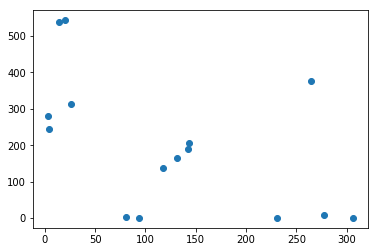

In [36]:
plt.scatter(x,y)
plt.show()

In [39]:
# saving the dfs sample to csvs for later use (just in case)
start = time.time()
for i in range(len(dfs)):
    filename = "OneMillRandomSample" + str(i+1) + ".csv"
    dfs[i].to_csv(filename)
end = time.time()
print(end - start)

58.50288915634155


In [40]:
# Cluster Packet Scatterplot
def slope_classifier1(k, x_coords, y_coords):    
    # Randomly assigning initial clusters
    slopeClusters = []
    for i in range(k):
        slopeClusters.append((random.uniform(0,math.pi/2)))
    
    # Finding the ratio of y to x (slope for each (x,y) coordinate)
    # Making x values of 0 very small to avoid divide by zero error
    xCopy = x_coords
    xCopy[xCopy==0] = 0.0000000000000000000001
    y = np.array(y_coords, dtype = 'float')
    x = np.array(xCopy, dtype = 'float')
    slopes = np.divide(y,x)
    
    
    # Instantiating and empty array of 0 as a place holder for the old slope clusters
    # will use this to calculate error as slope clusters change each iteration. Once the error
    # is 0, the clusters have stabilized
    old_slopeClusters = np.zeros(len(slopeClusters))
    error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
  
    # Running a loop until centroids stabilize (percent change from old cluster values to new is 0)
    while error.any() != 0:
        
        # Instantiating an empty array of 0s that will be populated with cluster assignments for each slope  
        clusters = np.zeros(len(slopes))
        
        # For each slope, find the cosine distance to each cluster. Cosine always return [0,1], with values
        # closer to 1 signifying that the two vectors are close; 0 that they are far apart. Finding the max
        # cosine value and the corresponding cluster will be assigned to that slope. 
        for i in range(len(slopes)):               
            distances = []
            for j in range(len(slopeClusters)):
                distances.append(cosine_similarity(slopes[i],slopeClusters[j]))
            cluster = np.argmax(distances)
            clusters[i] = cluster
        
               
        # Making a deep copy of the old centroids to use later for clacluating error
        old_slopeClusters = deepcopy(slopeClusters)
        
        
        # Finding new centroids by taking average of the values assigned to each cluster and
        # replacing the old cluster values with the new averages
        for m in range(k):
            points = [slopes[j] for j in range(len(slopes)) if clusters[j] == m]              
            slopeClusters[m] = sum(points)/len(points)
        
        # Finding the percent change from the old cluster assignments to the new cluster assignments
        error = np.divide(np.subtract(slopeClusters, old_slopeClusters), old_slopeClusters)
        
    return clusters

In [48]:
# Clustering the clusters
finalClusters = slope_classifier1(3, x, y)
dfCentroids = pd.DataFrame(centers)
dfCentroids['ClusterAssigns'] = finalClusters
dfCentroids.head()

/apps/software/standard/core/anaconda/5.2.0-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


,0,1,ClusterAssigns
0,80.563865,1.834125,1.0
1,19.688417,543.405583,1.0
2,13.917618,538.555544,1.0
3,305.920472,0.609328,2.0
4,3.413708,281.305044,1.0


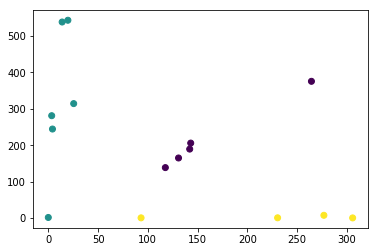

In [49]:
# Double Chekcing results are what's expected
plt.scatter(x,y, c=finalClusters)
plt.show()

In [50]:
# Finding ultimate centroids
cen0 = dfCentroids[dfCentroids['ClusterAssigns']==0].mean().values.tolist()[0:2]
cen1 = dfCentroids[dfCentroids['ClusterAssigns']==1].mean().values.tolist()[0:2]
cen2 = dfCentroids[dfCentroids['ClusterAssigns']==2].mean().values.tolist()[0:2]

In [54]:
print(cen0)
print(cen1)
print(cen2)

[159.66765488683043, 215.06614547335477]
[24.549309686949808, 320.7131954900896]
[226.66605526485787, 2.516843404651521]


In [55]:
ultimateCentroids = pd.DataFrame([cen0, cen1, cen2])
ultimateCentroids

,0,1
0,159.667655,215.066145
1,24.549310,320.713195
2,226.666055,2.516843


In [56]:
# Saving centroids to csv 
ultimateCentroids.to_csv("UltimateCentroids_From_5_1mill_samples")